In [1]:
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

def make_session(total_retries: int = 3, backoff: float = 0.3) -> requests.Session:
    s = requests.Session()
    retry = Retry(
        total = total_retries,
        connect = total_retries,
        read = total_retries,
        backoff_factor = backoff,
        status_forcelist = (429,500,502,503,504),
        allowed_methods =["GET", "POST", "PUT", "DELETE", "HEAD", "OPTIONS"])
    adapter = HTTPAdapter(max_retries = retry)
    s.mount("http://", adapter); s.mount("https://", adapter)
    return s

def post_json(s: requests.Session, url: str, payload: dict | None = None):
    r = s.post(url, json=payload or {}); r.raise_for_status(); return r.json()

def get_json(s: requests.Session, url: str, payload: dict | None = None):
    r = s.get(url, json=payload or {}); r.raise_for_status(); return r.json()

def _require_keys(obj, keys, label = "object"):
    missing = [k for k in keys if k not in obj]
    assert not missing, f"{label} missing keys: {missing}. Got keys: {list(obj.keys())}"

def _require_type(value, typ, label):
    assert isinstance(value, typ), f"{label} expected {typ}, got {type(value)}"

In [2]:
import requests
import time
from urllib.parse import quote
import nest_asyncio
nest_asyncio.apply()
import asyncio
import matplotlib.pyplot as plt
import pandas as pd
import json
import plotly.graph_objects as go
import scipy.stats as stats
import numpy as np
from pprint import pprint
from datetime import datetime
from pathlib import Path

In [3]:


BASE_URL = "http://127.0.0.1:8000"
SECTOR   = "Energy Grid"
HAZARD   = "Heat Stress"

s = make_session()

# 1) Call /api/get-climate
climate_payload = {
    "hazard": HAZARD,
    "scenario": "rcp85",
    "domain": "NAM-22i",
    "lat": 36.5323,
    "lon": -116.9325,
    "num_cells": 0,
    
    "prior_years": 5,
    "future_years": 5,
    
    "climate_model": "all",
    "aggregation_method": "mean",
    "aggregation_q": None,
    "aggregate_over_member_id": True,
}

prepared = post_json(s, f"{BASE_URL}/api/get-climate", climate_payload)

_require_keys(prepared, ['bounding_box'], "climate")
assert ("data" in prepared) or ("members" in prepared)

times_iso = []
for t in prepared.get("times") or []:
    if isinstance(t, (int,float)) and t > 1e12: t = t/1000
    if isinstance(t, (int,float)):
        times_iso.append(datetime.fromtimestamp(t).strftime("%Y-%m-%d"))
    else:
        times_iso.append(str(t).split("T")[0])

member_ids = None
if isinstance("members", list) and not prepared.get("data"):
    member_ids = [m.get("member_id") for m in prepared["members"] if isinstance(m, dict) and m.get("member_id")]

var_map = {}
if isinstance(prepared.get("variables"), list):
    long_names = prepared.get("variable_long_names") or []
    for i, code in enumerate(prepared["variables"]):
        var_map[code] = long_names[i] if i < len(long_names) else code

print("get-climate ok; keys:", list(prepared.keys()))
print("    bounding_box:", prepared["bounding_box"])
print("    variables   :", prepared.get("variable_long_names", prepared.get("variables")))


print("Top-level keys of prepared:")
pprint(list(prepared.keys()))




get-climate ok; keys: ['variables', 'variable_long_names', 'times', 'bounding_box', 'climate_analysis', 'data', 'members', 'aoi_demographics']
    bounding_box: {'min_lat': 36.5, 'max_lat': 36.75, 'min_lon': -117.0, 'max_lon': -116.75}
    variables   : ['Near-Surface Air Temperature', 'Near-Surface Relative Humidity', 'Heat Index']
Top-level keys of prepared:
['variables',
 'variable_long_names',
 'times',
 'bounding_box',
 'climate_analysis',
 'data',
 'members',
 'aoi_demographics']


This is for EDA only...climate_df doesn't exist in the application, so don't use it to prototype features.

,Near-Surface Air Temperature,Near-Surface Relative Humidity,Heat Index
2020-01-01 12:00:00,37.215649,49.210316,37.215649
2020-01-02 12:00:00,35.637024,49.739426,35.637024
2020-01-03 12:00:00,36.091255,53.783001,36.091255
2020-01-04 12:00:00,35.677673,53.369827,35.677673
2020-01-05 12:00:00,35.621754,49.156952,35.621754


       Near-Surface Air Temperature  Near-Surface Relative Humidity  \
count                   4018.000000                     4018.000000   
mean                      61.083548                       29.423735   
std                       17.564193                       11.033169   
min                       27.538727                       10.859234   
25%                       44.349129                       19.845941   
50%                       60.157024                       27.253880   
75%                       78.562859                       38.925823   
max                       89.786713                       61.918762   

        Heat Index  
count  4018.000000  
mean     61.083548  
std      17.564193  
min      27.538727  
25%      44.349129  
50%      60.157024  
75%      78.562859  
max      89.786713  


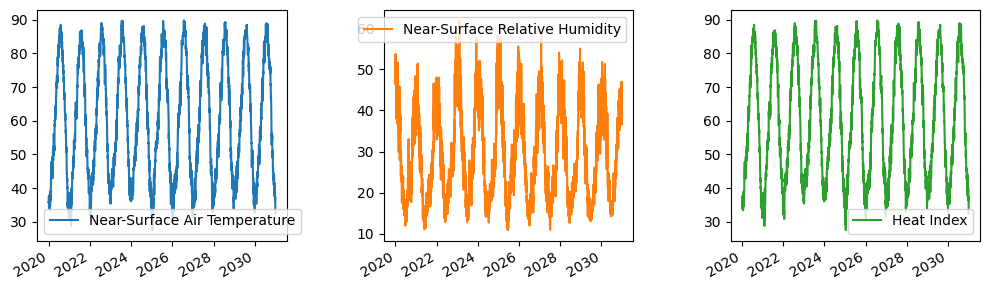

In [4]:
# 2) Build DataFrame from the first grid-cell
cells = prepared.get("data") or []
if not cells and "members" in prepared:
    m0 = prepared['members'][0]
    cells = m0.get("data") or []
    
times = pd.to_datetime(prepared["times"])
cell_data = prepared['data'][0]["climate"]
climate_df = pd.DataFrame(cell_data, index=times)
climate_df.columns = prepared["variable_long_names"]
# 3) Preview
display(climate_df.head())

print(climate_df.describe())
climate_df.plot(figsize=(10,3), subplots=True, layout=(1,len(climate_df.columns)))
plt.tight_layout()

In [5]:
# 2) Call /api/get-infrastructure using the bounding box from Cell 1
bbox = prepared["bounding_box"]
infra_payload = {
    "sector": SECTOR,
    "hazard": HAZARD,
    "min_lat": bbox["min_lat"],
    "max_lat": bbox["max_lat"],
    "min_lon": bbox["min_lon"],
    "max_lon": bbox["max_lon"]
}

infra_json = post_json(s, f"{BASE_URL}/api/get-infrastructure", infra_payload)
assets = infra_json.get("infrastructure") if isinstance(infra_json, dict) else infra_json
_require_type(assets, list, "infrastructure array")
print("get-infrastructure ok; assets:", len(assets))


get-infrastructure ok; assets: 0


In [6]:
assets[0]

IndexError: list index out of range

### Identify Hot Streaks

In [ ]:
# Hot-streaks from `prepared` → frontend-ready JSON + HTML preview (no matplotlib)
# Requires: `prepared` from /api/get-climate in earlier cell.

# ---------------- config you can tweak ----------------
VARIABLE       = "tas"      # your heat-index key; will auto-fallback if different
GRID_IDX       = 0         # which grid cell to use for preview
MEMBER_IDX     = 0         # used only if per-member
METHOD         = "quantile"     # 'quantile' or 'absolute'
Q              = 0.90            # quantile if METHOD=='quantile'
ABS_THRESHOLD  = 95.0            # °F/°C if METHOD=='absolute'
MIN_STREAK     = 3               # consecutive days required to count
OUT_DIR        = "C://Users/Hallsm/Downloads"     # where to write files
# ------------------------------------------------------

def _to_dt_index(times_list):
    out = []
    for t in times_list or []:
        if isinstance(t, (int, float)):
            if t > 1e12: t = t/1000.0  # ms → s
            out.append(datetime.fromtimestamp(t))
        else:
            out.append(pd.to_datetime(str(t)))
    return pd.DatetimeIndex(out)

def _extract_series(prepared, variable="hi", grid_index=0, member_index=0):
    times = _to_dt_index(prepared.get("times") or [])
    # prefer aggregated
    if isinstance(prepared.get("data"), list) and prepared["data"]:
        clim = prepared["data"][grid_index]["climate"]
    # fallback to per-member
    elif isinstance(prepared.get("members"), list) and prepared["members"]:
        clim = prepared["members"][member_index]["data"][grid_index]["climate"]
    else:
        raise RuntimeError("No climate series available (neither 'data' nor 'members').")

    # try common aliases
    val = (clim.get(variable) or clim.get("heat_index") or clim.get("HI") or
           clim.get("HeatIndex") or clim.get("heatindex"))
    if val is None:
        # last resort: pick any key containing 'hi'
        cand = [k for k in clim.keys() if "hi" in k.lower().replace("_","")]
        if not cand:
            raise RuntimeError(f"Couldn't find Heat Index series in keys: {list(clim.keys())[:8]} ...")
        variable = cand[0]
        val = clim[variable]

    # align x/y lengths defensively
    y = np.asarray(val, dtype=float)
    x = times[:len(y)]
    ser = pd.Series(y, index=x).sort_index()
    # export friendly x array (YYYY-MM-DD)
    x_iso = [d.strftime("%Y-%m-%d") for d in ser.index]
    return x_iso, ser, variable

def _find_streaks(series: pd.Series, threshold: float, min_len=1):
    ser = series.dropna().sort_index()
    mask = (ser >= threshold).astype(int).values
    # run-length encode
    edges = np.diff(np.r_[0, mask, 0])
    starts = np.where(edges == 1)[0]
    ends   = np.where(edges == -1)[0]  # exclusive
    out = []
    for s_i, e_i in zip(starts, ends):
        L = int(e_i - s_i)
        if L < min_len: 
            continue
        out.append({
            "start": ser.index[s_i].strftime("%Y-%m-%d"),
            "end":   ser.index[e_i-1].strftime("%Y-%m-%d"),
            "length_days": L,
        })
    return out

# 1) extract series
x, series, var_used = _extract_series(prepared, VARIABLE, GRID_IDX, MEMBER_IDX)

# 2) threshold
if METHOD == "quantile":
    T = float(np.nanquantile(series.values, Q))
    threshold_meta = {"type":"quantile","q":Q,"value":T}
else:
    T = float(ABS_THRESHOLD)
    threshold_meta = {"type":"absolute","value":T}

# 3) streaks
streaks = _find_streaks(series, T, min_len=MIN_STREAK)

# 4) write frontend-ready JSON
out_dir = Path(OUT_DIR)
out_dir.mkdir(parents=True, exist_ok=True)

# timeseries + overlay (so GraphContainer/charting can draw the line & shade windows)
ts_payload = {
    "variable": var_used,
    "x": x,                               # ["YYYY-MM-DD", ...]
    "y": series.astype(float).tolist(),   # [values...]
    "threshold": threshold_meta,          # {type, q?, value}
    "streaks": streaks,                   # [{start,end,length_days}]
    "meta": {
        "grid_index": GRID_IDX,
        "member_index": MEMBER_IDX if "members" in prepared else None
    }
}
with open(out_dir/"hot_streaks_timeseries.json", "w", encoding="utf-8") as f:
    json.dump(ts_payload, f, indent=2)

# also a minimal streaks-only file if you prefer overlays separate
with open(out_dir/"hot_streaks.json", "w", encoding="utf-8") as f:
    json.dump({"threshold": threshold_meta, "streaks": streaks}, f, indent=2)

print(f"✅ wrote {out_dir/'hot_streaks_timeseries.json'}")
print(f"✅ wrote {out_dir/'hot_streaks.json'}   (streaks-only)")

# 5) tiny HTML preview (no frontend changes; just for visual check)
#    Uses Plotly via CDN to draw a line + shaded streak windows + threshold.
html = f"""<!DOCTYPE html>
<html><head><meta charset="utf-8"/><title>Hot Streaks Preview</title>
<script src="https://cdn.plot.ly/plotly-2.32.0.min.js"></script>
<style>body{{font-family:system-ui,Segoe UI,Roboto,Helvetica,Arial,sans-serif;margin:12px}}</style>
</head><body>
<h3>Hot Streaks Preview — variable: {var_used}, T={T:.2f} ({threshold_meta['type']})</h3>
<div id="chart" style="width:100%;height:400px"></div>
<script>
const x = {json.dumps(x)};
const y = {json.dumps(series.astype(float).tolist())};
const streaks = {json.dumps(streaks)};
const T = {T};

const shapes = streaks.map(s => ({{
  type:'rect', xref:'x', yref:'paper',
  x0:s.start, x1:s.end, y0:0, y1:1,
  fillcolor:'rgba(255,0,0,0.15)', line:{{width:0}}
}}));
if (x.length) {{
  shapes.push({{
    type:'line', xref:'x', yref:'y',
    x0:x[0], x1:x[x.length-1], y0:T, y1:T,
    line:{{dash:'dash', width:1}}
  }});
}}
const trace = {{ x, y, type:'scatter', mode:'lines',
  hovertemplate:'%{{x}}<br>HI=%{{y:.1f}}<extra></extra>' }};
const layout = {{
  margin:{{l:45,r:15,t:40,b:40}},
  title:'Heat Index with Hot Streaks',
  xaxis:{{type:'date', automargin:true}},
  yaxis:{{title:'Heat Index', automargin:true}},
  shapes
}};
Plotly.newPlot('chart', [trace], layout, {{responsive:true, displaylogo:false}});
</script>
</body></html>"""
(out_dir/"hot_streaks_preview.html").write_text(html, encoding="utf-8")



✅ wrote C:\Users\Hallsm\Downloads\hot_streaks_timeseries.json
✅ wrote C:\Users\Hallsm\Downloads\hot_streaks.json   (streaks-only)
👀 open C:\Users\Hallsm\Downloads\hot_streaks_preview.html to see ribbon overlay


In [ ]:
# Ambient ≥ 86°F streaks (≥ MIN_STREAK days) + HTML preview (Plotly)
# Assumes `prepared` from /api/get-climate already exists.

from datetime import datetime
from pathlib import Path
import numpy as np, pandas as pd, json

# --- only tweak these if you want ---
VARIABLE   = "tas"    # <-- your ambient temperature key (in °F, as your backend guarantees)
GRID_IDX   = 0
MEMBER_IDX = 0         # used only if per-member
MIN_STREAK = 3
OUT_DIR    = "C://Users/Hallsm/Downloads"
THRESHOLD  = 86.0      # °F cutoff
# ------------------------------------

def _to_idx(times):
    out = []
    for t in times or []:
        if isinstance(t,(int,float)):
            if t > 1e12: t = t/1000.0  # ms -> s
            out.append(datetime.fromtimestamp(t))
        else:
            out.append(pd.to_datetime(str(t)))
    return pd.DatetimeIndex(out)

def extract_series(prepared, var):
    times = _to_idx(prepared.get("times") or [])
    if prepared.get("data"):  # aggregated
        clim = prepared["data"][GRID_IDX]["climate"]
    else:                      # per-member
        clim = prepared["members"][MEMBER_IDX]["data"][GRID_IDX]["climate"]
    y = np.asarray(clim[var], dtype=float)
    x = times[:len(y)]
    ser = pd.Series(y, index=x).sort_index()
    x_iso = [d.strftime("%Y-%m-%d") for d in ser.index]
    return x_iso, ser

def find_runs_ge(series: pd.Series, threshold: float, min_len=3):
    ser = series.dropna().sort_index()
    mask = (ser >= threshold).astype(int).values
    edges = np.diff(np.r_[0, mask, 0])
    starts = np.where(edges == 1)[0]
    ends   = np.where(edges == -1)[0]  # exclusive
    out = []
    for s, e in zip(starts, ends):
        L = int(e - s)
        if L >= min_len:
            out.append({
                "start": ser.index[s].strftime("%Y-%m-%d"),
                "end":   ser.index[e-1].strftime("%Y-%m-%d"),
                "length_days": L
            })
    return out

# 1) extract ambient series
x, series = extract_series(prepared, VARIABLE)

# 2) compute streaks (ambient ≥ 86°F for at least MIN_STREAK consecutive days)
streaks = find_runs_ge(series, threshold=THRESHOLD, min_len=MIN_STREAK)

# 3) write frontend-ready JSON (same shape you used for HI)
payload = {
    "variable": VARIABLE,
    "x": x,
    "y": series.astype(float).tolist(),
    "threshold": { "type": "absolute", "value": THRESHOLD, "units": "F" },
    "streaks": streaks,
    "meta": { "grid_index": GRID_IDX, "member_index": MEMBER_IDX if "members" in prepared else None }
}
out_dir = Path(OUT_DIR); out_dir.mkdir(parents=True, exist_ok=True)
json_path = out_dir / "ambient_86f_streaks_timeseries.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(payload, f, indent=2)
print(f"✅ wrote {json_path}  |  streaks: {len(streaks)}")

# 4) tiny HTML preview 
html_path = out_dir / "ambient_86f_streaks_preview.html"
html = f"""<!DOCTYPE html>
<html><head><meta charset="utf-8"/><title>Ambient ≥ {THRESHOLD}°F — Streaks</title>
<script src="https://cdn.plot.ly/plotly-2.32.0.min.js"></script>
<style>body{{font-family:system-ui,Segoe UI,Roboto,Helvetica,Arial,sans-serif;margin:12px}}</style>
</head><body>
<h3>Ambient Temperature ≥ {THRESHOLD}°F — {MIN_STREAK}+ day streaks (variable: {VARIABLE})</h3>
<div id="chart" style="width:100%;height:400px"></div>
<script>
const x = {json.dumps(x)};
const y = {json.dumps(series.astype(float).tolist())};
const streaks = {json.dumps(streaks)};
const T = {THRESHOLD};

const shapes = streaks.map(s => ({{
  type:'rect', xref:'x', yref:'paper',
  x0:s.start, x1:s.end, y0:0, y1:1,
  fillcolor:'rgba(255,0,0,0.15)', line:{{width:0}}
}}));
if (x.length) {{
  shapes.push({{
    type:'line', xref:'x', yref:'y',
    x0:x[0], x1:x[x.length-1], y0:T, y1:T,
    line:{{dash:'dash', width:1}}
  }});
}}
const trace = {{ x, y, type:'scatter', mode:'lines',
  hovertemplate:'%{{x}}<br>Temp=%{{y:.1f}}°F<extra></extra>' }};
const layout = {{
  margin:{{l:45,r:15,t:40,b:40}},
  title:'Ambient Temperature with Streaks',
  xaxis:{{type:'date', automargin:true}},
  yaxis:{{title:'Temperature (°F)', automargin:true}},
  shapes
}};
Plotly.newPlot('chart', [trace], layout, {{responsive:true, displaylogo:false}});
</script>
</body></html>"""
html_path.write_text(html, encoding="utf-8")
print(f"open {html_path} to view the shaded timeline preview")

✅ wrote C:\Users\Hallsm\Downloads\ambient_86f_streaks_timeseries.json  |  streaks: 25
👀 open C:\Users\Hallsm\Downloads\ambient_86f_streaks_preview.html to view the shaded timeline preview


In [6]:
with open("../frontend/Mongo/acclimate_db.hbom_definitions.json") as f: 
    hbom_data = json.load(f)

def extract_fragility_curves(components, hazard_name="Heat Stress"):
    curves = []

    def walk(comp):
        label = comp.get("label", "Unknown")
        hazard = comp.get("hazards", {}).get(hazard_name)
        if hazard:
            model = hazard.get("fragility_model")
            params = hazard.get("fragility_params", {})
            curves.append({
                "label": label,
                "model": model,
                **params
            })
        for sub in comp.get("subcomponents", []):
            walk(sub)

    for c in hbom_data[0]["components"]:
        walk(c)

    return curves

fragility_definitions = extract_fragility_curves(hbom_data[0]["components"])
df_models = pd.DataFrame(fragility_definitions)
df_models.head()


,label,model,scale,shape,median,dispersion,mid_point,slope
0,Line Terminal,weibull,77.46,2.18,NaN,NaN,NaN,NaN
1,Surge Arrester,weibull,82.11,2.31,NaN,NaN,NaN,NaN
2,Line Disconnector,weibull,69.82,2.48,NaN,NaN,NaN,NaN
3,Circuit Breaker,weibull,89.82,2.65,NaN,NaN,NaN,NaN
4,Capacity Voltage Transformer,lognormal,NaN,NaN,115.15,0.86,NaN,NaN


In [17]:


x_vals = np.linspace(50, 130, 500)
fig = go.Figure()

for _, row in df_models.iterrows():
    label = row["label"]
    model = row["model"].lower()

    if model == "weibull":
        scale = row["scale"]
        shape = row["shape"]
        y_vals = 1 - np.exp(-(x_vals / scale)**shape)
    elif model == "lognormal":
        median = row["median"]
        sigma = row["dispersion"]
        mu = np.log(median)
        y_vals = stats.lognorm.cdf(x_vals, s=sigma, scale=np.exp(mu))
    elif model == "logistic":
        mid = row["mid_point"]
        slope = row["slope"]
        y_vals = 1 / (1 + np.exp(-slope * (x_vals - mid)))
    else:
        continue  # unknown model type

    fig.add_trace(go.Scatter(
        x=x_vals, y=y_vals, mode="lines", name=label
    ))

fig.update_layout(
    title="Fragility Curves for Heat Stress",
    xaxis_title="Hazard Intensity (e.g., Temperature)",
    yaxis_title="Probability of Failure",
    template="plotly_white"
)
fig.show()

### Create a synthetic heat wave

Processing node: Substation for hazard: Heat Stress
  No direct hazard data for node: Substation
Processing node: Bay: Incoming Feeder for hazard: Heat Stress
  No direct hazard data for node: Bay: Incoming Feeder
Processing node: Line Terminal for hazard: Heat Stress
    Node: Line Terminal, Var: tas, Grid 0, final_pof: 0.0
    Node: Line Terminal, Var: tas, Grid 1, final_pof: 0.0
    Node: Line Terminal, Var: tas, Grid 2, final_pof: 0.0
    Node: Line Terminal, Var: tas, Grid 3, final_pof: 0.0
    Node: Line Terminal, Var: tas, Grid 4, final_pof: 0.0
    Node: Line Terminal, Var: tas, Grid 5, final_pof: 0.0
    Node: Line Terminal, Var: tas, Grid 6, final_pof: 0.0
    Node: Line Terminal, Var: tas, Grid 7, final_pof: 0.0
    Node: Line Terminal, Var: tas, Grid 8, final_pof: 0.0
    Node: Line Terminal, Var: hurs, Grid 0, final_pof: 0.0
    Node: Line Terminal, Var: hurs, Grid 1, final_pof: 0.0
    Node: Line Terminal, Var: hurs, Grid 2, final_pof: 0.0
    Node: Line Terminal, Var: hu

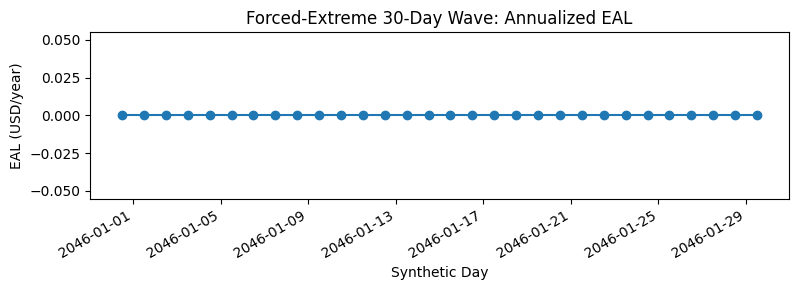

In [69]:
import copy, nest_asyncio, asyncio
import pandas as pd
import matplotlib.pyplot as plt

from crud import get_filtered_hbom
from econAnalysis import compute_economic_timeseries_for_hbom
from main import items_by_uuid, items_by_type

# 1) Alias your existing climate payload
prepared_data = prepared   # from your /api/get-climate JSON

# 2) Build a “max‐extreme” 30-day wave
M = 30
# for time‐axis we can just pick the last true timestamp + offsets:
base = pd.to_datetime(prepared_data["times"][-1])
times_syn = [base + pd.Timedelta(days=i) for i in range(M)]

# 3) For each cell, take the **max** of its tas/hurs arrays and repeat
cells_syn = []
for cell in prepared_data["data"]:
    raw = cell["climate"]  # this dict has keys: 'tas','hurs','hi'
    # force both tas and hurs to their absolute maxima
    forced = {
        var: [ max(raw[var]) ] * M
        for var in ("tas","hurs")
        if var in raw
    }
    cells_syn.append({
        "grid_index": cell["grid_index"],
        "bounds":     cell["bounds"],
        "data":       forced      # note: compute_economic expects “data”, not “climate”
    })

synthetic = {
    **prepared_data,
    "times": times_syn,
    "data":  cells_syn
}

# 4) Recompute the economic time series on this forced‐extreme wave
nest_asyncio.apply()
hbom = asyncio.get_event_loop().run_until_complete(
    get_filtered_hbom(SECTOR, HAZARD)
)
ts_syn = compute_economic_timeseries_for_hbom(
    hbom, HAZARD,
    items_by_uuid, items_by_type,
    synthetic
)

# 5) Flatten to leaves and build the system EAL Series
def flatten(nodes):
    out = []
    for n in nodes:
        out.append(n)
        out.extend(flatten(n.get("components", []) + n.get("subcomponents", [])))
    return out

leaves = [n for n in flatten(ts_syn["components"])
          if not (n.get("components") or n.get("subcomponents"))]

system_eal = pd.Series(
    [ sum(n["time_series"]["eal_timeseries"][i] for n in leaves)
      for i in range(M) ],
    index=times_syn,
    name="Extreme‐Wave EAL"
)

# 6) Plot it—now you should see a clear jump from zero to a high plateau
plt.figure(figsize=(8,3))
system_eal.plot(marker="o", linestyle="-")
plt.title("Forced‐Extreme 30-Day Wave: Annualized EAL")
plt.ylabel("EAL (USD/year)")
plt.xlabel("Synthetic Day")
plt.tight_layout()
plt.show()


In [ ]:
# 3) Call /api/prewarm/{sector}/{hazard}
prewarm_url = f"{BASE_URL}/api/prewarm/{quote(SECTOR)}/{quote(HAZARD)}"
resp = requests.post(prewarm_url)
resp.raise_for_status()

print(" prewarm status:", resp.status_code, resp.json())
# wait for the background task to finish its cache writes
time.sleep(5)


✔️ prewarm status: 200 {'status': 'prewarming_started'}


In [4]:
# 4) Fetch HBOM directly via our helper
hbom = asyncio.get_event_loop().run_until_complete(
    get_filtered_hbom(SECTOR, HAZARD)
)

# Quick inspect
print("HBOM keys:", hbom.keys())
print(" # of top‐level components:", len(hbom.get("components", [])))


HBOM keys: dict_keys(['sector', 'components', 'id'])
 # of top‐level components: 4


In [34]:
# 5) GET /api/economic-timeseries  (adapted for new tree shape)
ts_url = f"{BASE_URL}/api/economic-timeseries/{quote(SECTOR)}/{quote(HAZARD)}"
ts_resp = requests.get(ts_url); ts_resp.raise_for_status()
hbom_ts = ts_resp.json()

# 1) pull out the roots
roots = hbom_ts["components"]

# 2) extract the common time axis from the first root
times = roots[0]["time_series"]["times"]

# 3) flatten the entire tree if you want all nodes
def flatten(nodes):
    out = []
    for n in nodes:
        out.append(n)
        out.extend(flatten(n.get("components", []) + n.get("subcomponents", [])))
    return out

all_nodes = flatten(roots)

leaf_nodes = [
    n for n in all_nodes
    if not (n.get("components") or n.get("subcomponents"))
]
print(" # leaf components:", len(leaf_nodes))

print("✔️ economic-timeseries status:", ts_resp.status_code)
print("  time points    :", times[:5], "…")
print("  # total nodes  :", len(all_nodes))


 # leaf components: 27
✔️ economic-timeseries status: 200
  time points    : ['2023-01-01T12:00:00.000000000', '2023-01-02T12:00:00.000000000', '2023-01-03T12:00:00.000000000', '2023-01-04T12:00:00.000000000', '2023-01-05T12:00:00.000000000'] …
  # total nodes  : 36


Component: Line Terminal
  times[0:5]: ['2023-01-01T12:00:00.000000000', '2023-01-02T12:00:00.000000000', '2023-01-03T12:00:00.000000000', '2023-01-04T12:00:00.000000000', '2023-01-05T12:00:00.000000000']
  eal[0:5]  : [0.0, 0.0, 0.0, 0.0, 0.0]
First non-zero EAL at leaf: Surge Arrester
  times[0:5]: ['2023-01-01T12:00:00.000000000', '2023-01-02T12:00:00.000000000', '2023-01-03T12:00:00.000000000', '2023-01-04T12:00:00.000000000', '2023-01-05T12:00:00.000000000']
  eal[0:5]  : [3827.9818062418312, 3827.9818062418312, 3827.9818062418312, 3827.9818062418312, 3827.9818062418312]


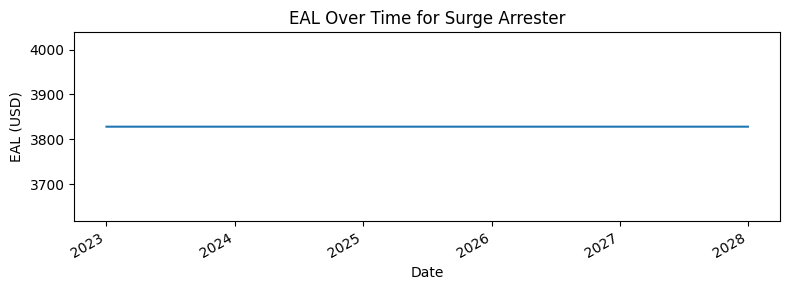

In [36]:
leaf = leaf_nodes[0]
ts = leaf["time_series"]
print("Component:", leaf["label"])
print("  times[0:5]:", ts["times"][:5])
print("  eal[0:5]  :", ts["eal_timeseries"][:5])

# find first leaf with any EAL > 0
nz_leaf = next(
    n for n in leaf_nodes
    if any(e > 0 for e in n["time_series"]["eal_timeseries"])
)

ts   = nz_leaf["time_series"]
label = nz_leaf["label"]
print("First non-zero EAL at leaf:", label)
print("  times[0:5]:", ts["times"][:5])
print("  eal[0:5]  :", ts["eal_timeseries"][:5])

import pandas as pd
import matplotlib.pyplot as plt

series = pd.Series(ts["eal_timeseries"], index=pd.to_datetime(ts["times"]), name=label)
plt.figure(figsize=(8,3))
series.plot()
plt.title(f"EAL Over Time for {label}")
plt.xlabel("Date")
plt.ylabel("EAL (USD)")
plt.tight_layout()
plt.show()


In [37]:
# --- Revised Cell 6: flatten & pick only leaf components -------------

from pprint import pprint

# flatten the full tree
def flatten(nodes):
    out = []
    for n in nodes:
        out.append(n)
        out.extend(flatten(n.get("components", []) + n.get("subcomponents", [])))
    return out

roots     = hbom_ts["components"]             # from Cell 5
times     = roots[0]["time_series"]["times"]  # same as before
all_nodes = flatten(roots)

# now pick only leaves (no children)
leaf_nodes = [
    n for n in all_nodes
    if not (n.get("components") or n.get("subcomponents"))
]

# 2) pick a time index (e.g. the last one)
idx     = len(times) - 1
t_label = times[idx]

# 3) aggregate over leaves only
total_value = sum(n["time_series"]["replacement_cost"] for n in leaf_nodes)
total_eal   = sum(n["time_series"]["eal_timeseries"][idx] for n in leaf_nodes)
at_risk     = [
    n for n in leaf_nodes
    if n["time_series"]["pof_timeseries"][idx] >= 0.5
]

summary = {
    "Leaf Components Count":        len(leaf_nodes),
    "Components at Risk Count":     len(at_risk),
    "Percent at Risk (leaves)":     len(at_risk) / len(leaf_nodes),
    "Total Leaf Asset Value":       total_value,
    f"Total Leaf EAL (at {t_label})": total_eal,
}

pprint(summary)


{'Components at Risk Count': 5,
 'Leaf Components Count': 27,
 'Percent at Risk (leaves)': 0.18518518518518517,
 'Total Leaf Asset Value': 2015000.0,
 'Total Leaf EAL (at 2027-12-31T12:00:00.000000000)': 863209.0910220565}


In [40]:
# Cell 6a

# Assume leaf_nodes, times, idx are already in your namespace from Cell 6

# Gather all “at risk” leaves
risk_rows = []
for n in leaf_nodes:
    pof = n["time_series"]["pof_timeseries"][idx]
    if pof >= 0.5:
        eal = n["time_series"]["eal_timeseries"][idx]
        risk_rows.append({
            "UUID":              n["uuid"],
            "Label":             n["label"],
            "Replacement Cost":  n["time_series"]["replacement_cost"],
            "PoF (today)":       pof,
            "EAL (today)":       eal,
        })

df_risk = pd.DataFrame(risk_rows).sort_values("PoF (today)", ascending=False)

# 1) Drop zero‐cost rows
df_nr = df_risk[df_risk["Replacement Cost"] > 0].copy()

# 2) Collapse duplicates by UUID (taking the max values)
df_nr = (
    df_nr
      .groupby("UUID", as_index=False)
      .agg({
          "Label":            "first",
          "Replacement Cost": "first",
          "PoF (today)":      "max",
          "EAL (today)":      "sum"   # if two nodes really did exist, sum their EALs
      })
)

# 3) Sort by highest EAL
df_nr = df_nr.sort_values("EAL (today)", ascending=False)

pd.options.display.float_format = '{:,.2f}'.format
display(df_nr)


,UUID,Label,Replacement Cost,PoF (today),EAL (today)
0,1b09306c-ad7e-450b-bf90-a15a883b8e76,Bus Disconnector,"33,000.00",0.53,"35,297.20"


Number of unique PoF values: 25
Unique PoF values sample: [0.0, 0.24492428201168015, 0.24571850554746355, 0.24810490442711797, 0.26124501712488146, 0.2690242945611876, 0.3299111524107673, 0.3343463994886362, 0.3530024484196035, 0.36351591994946664] ...

PoF value counts:


PoF
0.00    5478
0.24    3652
0.25    3652
0.25    3652
0.26    3652
0.27    1826
0.33    1826
0.33    1826
0.35    1826
0.36    1826
Name: count, dtype: int64

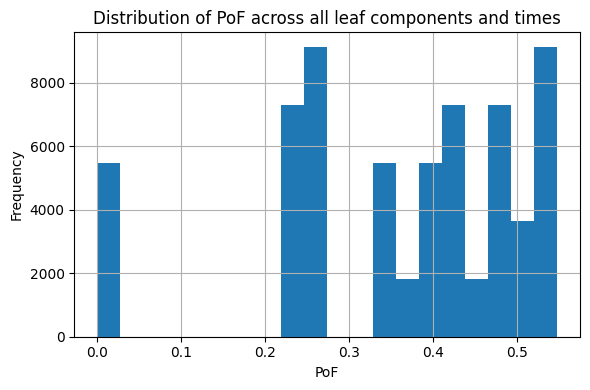

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Flatten PoF series across all leaf nodes
all_pofs = []
for node in leaf_nodes:
    all_pofs.extend(node["time_series"]["pof_timeseries"])

# Unique PoF values
unique_vals = sorted(set(all_pofs))
print(f"Number of unique PoF values: {len(unique_vals)}")
print("Unique PoF values sample:", unique_vals[:10], "...")

# Frequency of unique PoF values
df_pof = pd.Series(all_pofs, name="PoF")
counts = df_pof.value_counts().sort_index()
print("\nPoF value counts:")
display(counts.head(10))

# Plot histogram of PoF distribution
plt.figure(figsize=(6,4))
df_pof.hist(bins=20)
plt.title("Distribution of PoF across all leaf components and times")
plt.xlabel("PoF")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


,total_eal
time,
2023-01-01 12:00:00,"871,778.99"
2023-01-02 12:00:00,"863,209.09"
2023-01-03 12:00:00,"871,778.99"
2023-01-04 12:00:00,"863,209.09"
2023-01-05 12:00:00,"871,778.99"


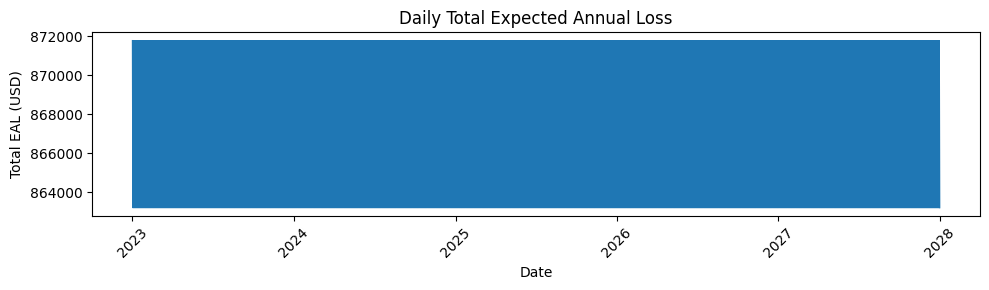

In [41]:
# Cell 7 – System time series

# Build a DataFrame of daily total EAL
df_system = pd.DataFrame({
    "time": pd.to_datetime(times),
    "total_eal": [
        sum(n["time_series"]["eal_timeseries"][i] for n in leaf_nodes)
        for i in range(len(times))
    ]
}).set_index("time")

# Quick preview
display(df_system.head())

# Plot daily EAL
plt.figure(figsize=(10,3))
plt.plot(df_system.index, df_system["total_eal"], linewidth=1)
plt.title("Daily Total Expected Annual Loss")
plt.xlabel("Date")
plt.ylabel("Total EAL (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [53]:
# How many distinct system EAL values?
unique_eals = df_system["total_eal"].unique()
print("Unique system EAL values:", sorted(unique_eals))


Unique system EAL values: [np.float64(863209.0910220565), np.float64(871778.9920802886)]


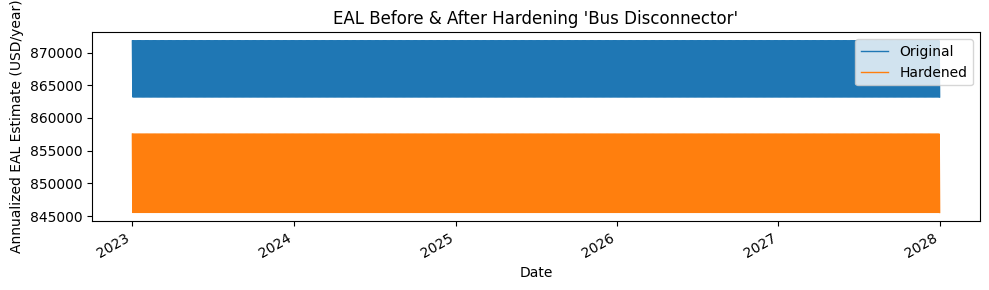

Hardened 2× 'Bus Disconnector' at $50,000 each
 → Total investment: $100,000
 → Avoided EAL in 2023: $5,817,319
 → ROI (avoided loss / cost): 58.17×


In [ ]:

# --- 1) Config: which asset & cost per unit ---
target = "Bus Disconnector"
unit_cost = 50_000  # $ per unit
count = sum(1 for n in leaf_nodes if n["label"] == target)
total_investment = count * unit_cost

# --- 2) Build original system series from leaf_nodes ---
orig_eal = pd.Series(
    [
        sum(n["time_series"]["eal_timeseries"][i] for n in leaf_nodes)
        for i in range(len(times))
    ],
    index=pd.to_datetime(times),
    name="Original"
)

# --- 3) Deep-copy leaves and apply hardening ---
h_leaves = copy.deepcopy(leaf_nodes)
for n in h_leaves:
    if n["label"] == target:
        # reduce PoF by 50%
        new_pof = [p * 0.5 for p in n["time_series"]["pof_timeseries"]]
        n["time_series"]["pof_timeseries"] = new_pof
        # recompute EAL = replacement_cost × new PoF
        rc = n["time_series"]["replacement_cost"]
        n["time_series"]["eal_timeseries"] = [rc * p for p in new_pof]

# --- 4) Build hardened system series (leaf-only) ---
hard_eal = pd.Series(
    [
        sum(n["time_series"]["eal_timeseries"][i] for n in h_leaves)
        for i in range(len(times))
    ],
    index=pd.to_datetime(times),
    name="Hardened"
)

# --- 5) Plot both for visual comparison ---
plt.figure(figsize=(10,3))
orig_eal.plot(label="Original", linewidth=1)
hard_eal.plot(label="Hardened", linewidth=1)
plt.legend()
plt.title(f"EAL Before & After Hardening '{target}'")
plt.ylabel("Annualized EAL Estimate (USD/year)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

# --- 6) Compute annual avoided EAL & ROI for the first calendar year ---
year0 = pd.to_datetime(times)[0].year
avoided = (orig_eal - hard_eal).loc[orig_eal.index.year == year0].sum()
roi     = avoided / total_investment if total_investment else float('nan')

# 7) Print results
print(f"Hardened {count}× '{target}' at ${unit_cost:,} each")
print(f" → Total investment: ${total_investment:,.0f}")
print(f" → Avoided EAL in {year0}: ${avoided:,.0f}")
print(f" → ROI (avoided loss / cost): {roi:.2f}×")


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


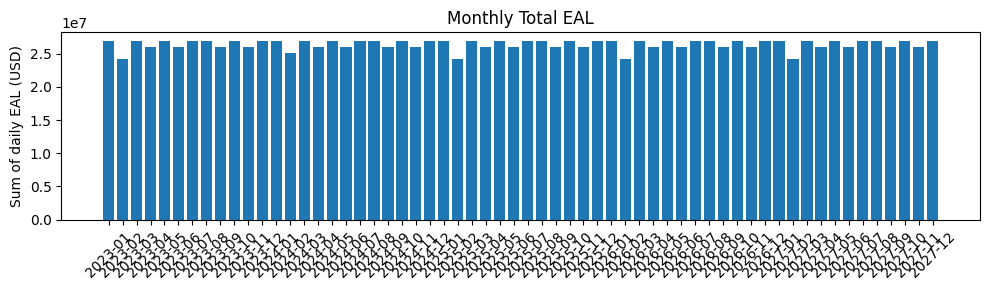

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


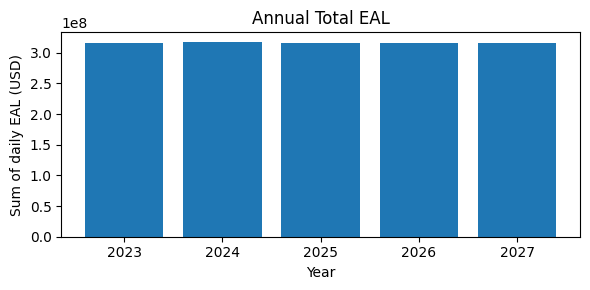

In [46]:
# Cell 8 – Monthly & annual aggregations
import matplotlib.dates as mdates

# Resample
monthly = df_system.resample("ME").sum()
yearly  = df_system.resample("YE").sum()

# Monthly bar chart
plt.figure(figsize=(10,3))
plt.bar(monthly.index.strftime("%Y-%m"), monthly["total_eal"])
plt.title("Monthly Total EAL")
plt.ylabel("Sum of daily EAL (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Yearly bar chart
plt.figure(figsize=(6,3))
plt.bar(yearly.index.year.astype(str), yearly["total_eal"])
plt.title("Annual Total EAL")
plt.ylabel("Sum of daily EAL (USD)")
plt.xlabel("Year")
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Daily Anomaly of Annualized EAL'}, xlabel='time', ylabel='Δ EAL (USD/year)'>

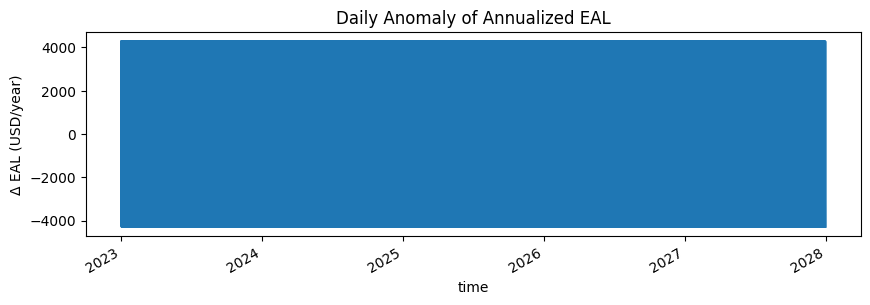

In [48]:
df_system["delta"] = df_system["total_eal"] - df_system["total_eal"].mean()
df_system["delta"].plot(
    figsize=(10,3), 
    title="Daily Anomaly of Annualized EAL",
    ylabel="Δ EAL (USD/year)"
)


C:\Users\steve\AppData\Local\Temp\ipykernel_17036\1252695232.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_max = df_system.resample("M")["total_eal"].max()


<Axes: title={'center': 'Monthly Peak Annualized EAL'}, xlabel='time', ylabel='Peak EAL (USD/year)'>

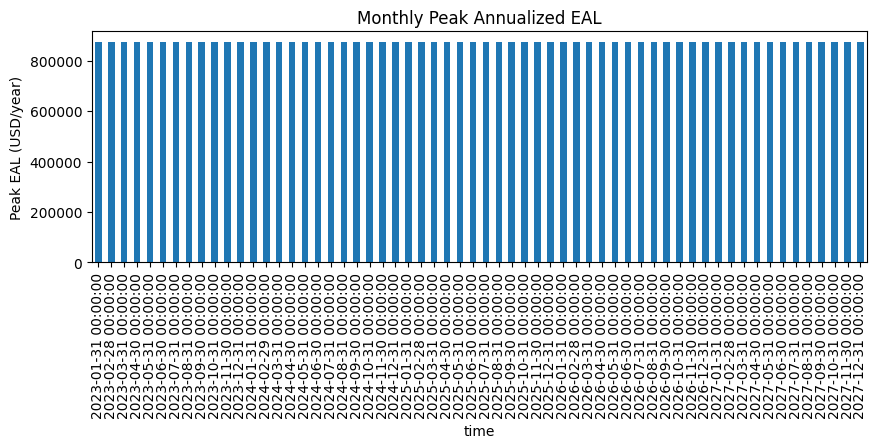

In [49]:
monthly_max = df_system.resample("M")["total_eal"].max()
monthly_max.plot(
    kind="bar", figsize=(10,3),
    title="Monthly Peak Annualized EAL",
    ylabel="Peak EAL (USD/year)"
)


Days above 95th percentile EAL: Empty DataFrame
Columns: [total_eal, delta]
Index: []


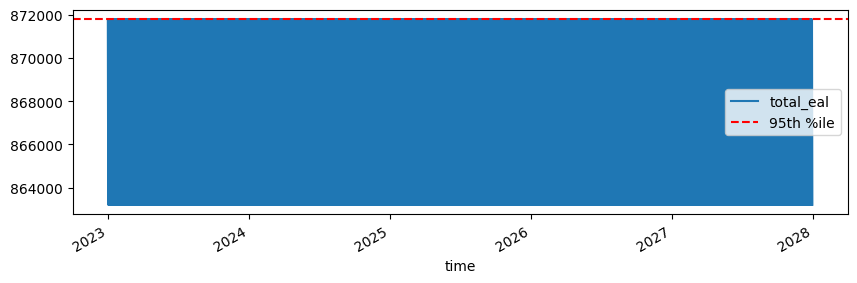

In [51]:
p95 = df_system["total_eal"].quantile(0.95)
spike_days = df_system[df_system["total_eal"] > p95]
print("Days above 95th percentile EAL:", spike_days)
ax = df_system["total_eal"].plot(figsize=(10,3))
ax.axhline(p95, color="red", linestyle="--", label="95th %ile")
ax.legend(); plt.show()


ValueError: Length of values (3652) does not match length of index (1826)

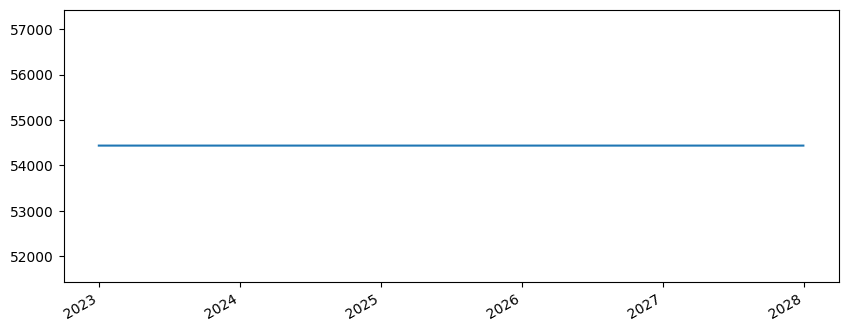

In [47]:
# Cell 9 – Which assets move the most?
import pandas as pd

# Compute ΔEAL range for each node
ranges = {
    n["label"]: max(n["time_series"]["eal_timeseries"]) - min(n["time_series"]["eal_timeseries"])
    for n in leaf_nodes
}
top5 = sorted(ranges.items(), key=lambda x: x[1], reverse=True)[:5]

# Plot each as a line
plt.figure(figsize=(10,4))
for label, _ in top5:
    node = next(n for n in leaf_nodes if n["label"] == label)
    series = pd.Series(node["time_series"]["eal_timeseries"], index=pd.to_datetime(times), name=label)
    series.plot()
plt.legend()
plt.title("Top 5 Components by EAL Range Over Time")
plt.xlabel("Date")
plt.ylabel("EAL (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Cell 10 – Aggregate current‐day EAL by type

# Build a small table of current‐day EAL per node
current_idx = len(times) - 1
rows = [
    {
      "type": n.get("component_type","Unknown"),
      "eal_current": n["time_series"]["eal_timeseries"][current_idx]
    }
    for n in leaf_nodes
]
df_type = pd.DataFrame(rows).groupby("type").sum().sort_values("eal_current", ascending=False)

display(df_type)


,eal_current
type,
capacitor_bank,"419,392.24"
circuit_breaker,"169,091.35"
current_transformer,"47,924.50"
bus_disconnector,"29,182.13"
circuit_switcher,"22,209.28"
wave_trap,"7,060.63"
surge_arrester,"3,101.28"
capacity_voltage_transformer,0.00
auxiliary_standby_power_system,0.00


In [63]:
import numpy as np

n_times = len(times)
print("Number of time‐points:", n_times)
print("First → last:", times[0], "→", times[-1])

# array of totals
total_eal = np.array([
    sum(node["time_series"]["eal_timeseries"][i] for node in leaf_nodes)
    for i in range(n_times)
])

print(f"Total EAL stats — min: {total_eal.min():.2f}, "
      f"max: {total_eal.max():.2f}, std: {total_eal.std():.2f}")
print("Unique total‐EAL values:", np.unique(total_eal).size)

# Which nodes vary the most?
ranges = [
    (node["label"],
     max(node["time_series"]["eal_timeseries"]) -
     min(node["time_series"]["eal_timeseries"]))
    for node in leaf_nodes
]
top5 = sorted(ranges, key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 components by EAL‐range:")
for label, delta in top5:
    print(f"  {label}: Δ{delta:.2f}")


Number of time‐points: 1096
First → last: 2024-01-01T12:00:00.000000000 → 2026-12-31T12:00:00.000000000
Total EAL stats — min: 697961.42, max: 706342.61, std: 4190.60
Unique total‐EAL values: 2

Top 5 components by EAL‐range:
  Circuit Breaker: Δ7030.89
  Circuit Breaker: Δ7030.89
  Bus Disconnector: Δ3356.21
  Bus Disconnector: Δ3356.21
  Current Transformer: Δ515.92


In [64]:
import pandas as pd

# assume you already have:
#   roots    = hbom_ts["components"]
#   times    = roots[0]["time_series"]["times"]
#   all_nodes = flatten(roots)

# 1) Build the Asset-Level Detail DataFrame
rows = []
for node in leaf_nodes:
    ts   = node["time_series"]
    current_idx = len(times) - 1           # or whatever slider index you want
    rows.append({
        "uuid":               node["uuid"],
        "label":              node["label"],
        "type":               node.get("component_type", "Unknown"),
        "replacement_cost":   ts["replacement_cost"],
        "population_exposed": node.get("population_exposed", 0),
        "pof_current":        ts["pof_timeseries"][current_idx],
        "eal_current":        ts["eal_timeseries"][current_idx],
        "max_eal":            max(ts["eal_timeseries"]),
        "day_of_max":         times[ts["eal_timeseries"].index(max(ts["eal_timeseries"]))],
    })

df_assets = pd.DataFrame(rows)
df_assets = df_assets.sort_values("eal_current", ascending=False)

# Display top 10 by current EAL
print("### Top 10 Assets by Current-Day EAL")
display(df_assets.head(10))

# 2) Summary Metrics
summary = {
    "Total Replacement Value": df_assets["replacement_cost"].sum(),
    "Total EAL (annual sum)":   df_assets["eal_current"].sum() * 365,  # approximate annual
    "% Assets at Risk":         (df_assets["pof_current"]>=0.5).mean(),
    "Peak Daily EAL":           df_assets["eal_current"].max(),
    "Date of Peak":             df_assets.loc[df_assets["eal_current"].idxmax(), "day_of_max"],
}
print("\n### High-Level Summary")
for k, v in summary.items():
    print(f"{k:25s}: {v}")

# 3) Aggregation by Component Type
print("\n### Aggregation by Component Type")
df_by_type = (
    df_assets
      .groupby("type")
      .agg({
        "uuid":              "count",
        "replacement_cost":  "sum",
        "eal_current":       "sum"
      })
      .rename(columns={"uuid":"count", "eal_current":"total_eal_current"})
      .sort_values("total_eal_current", ascending=False)
)
display(df_by_type)


### Top 10 Assets by Current-Day EAL


,uuid,label,type,replacement_cost,population_exposed,pof_current,eal_current,max_eal,day_of_max
17,7c82d055-06ab-4893-8ede-4d917cfe8c45,Capacitor Bank,capacitor_bank,"1,100,000.00",0,0.38,"419,392.24","419,392.24",2024-01-01T12:00:00.000000000
11,d658b486-2a8e-4579-baa6-ec4ce6a660ff,Circuit Breaker,circuit_breaker,"165,000.00",0,0.39,"63,568.21","70,599.10",2024-01-01T12:00:00.000000000
7,d658b486-2a8e-4579-baa6-ec4ce6a660ff,Circuit Breaker,circuit_breaker,"165,000.00",0,0.39,"63,568.21","70,599.10",2024-01-01T12:00:00.000000000
3,11bf6f0d-11c9-42ee-9498-727ea65fb625,Circuit Breaker,circuit_breaker,"165,000.00",0,0.25,"41,954.92","41,954.92",2024-01-01T12:00:00.000000000
13,82f97adf-76a9-4882-80be-eda1b5ae78fd,Current Transformer,current_transformer,"117,500.00",0,0.20,"23,962.25","24,478.17",2024-01-01T12:00:00.000000000
5,82f97adf-76a9-4882-80be-eda1b5ae78fd,Current Transformer,current_transformer,"117,500.00",0,0.20,"23,962.25","24,478.17",2024-01-01T12:00:00.000000000
16,0afd8a94-c219-4aeb-ac59-561f663c3248,Circuit Switcher,circuit_switcher,"85,000.00",0,0.26,"22,209.28","22,209.28",2024-01-01T12:00:00.000000000
10,1b09306c-ad7e-450b-bf90-a15a883b8e76,Bus Disconnector,bus_disconnector,"33,000.00",0,0.44,"14,591.07","14,591.07",2024-01-02T12:00:00.000000000
8,1b09306c-ad7e-450b-bf90-a15a883b8e76,Bus Disconnector,bus_disconnector,"33,000.00",0,0.44,"14,591.07","14,591.07",2024-01-02T12:00:00.000000000
15,d6775846-64a3-4ad5-b0e2-f06c9d1e4436,Wave Trap,wave_trap,"25,000.00",0,0.28,"7,060.63","7,060.63",2024-01-01T12:00:00.000000000



### High-Level Summary
Total Replacement Value  : 2015000.0
Total EAL (annual sum)   : 254755917.11318797
% Assets at Risk         : 0.0
Peak Daily EAL           : 419392.24193667306
Date of Peak             : 2024-01-01T12:00:00.000000000

### Aggregation by Component Type


,count,replacement_cost,total_eal_current
type,,,
capacitor_bank,1,"1,100,000.00","419,392.24"
circuit_breaker,3,"495,000.00","169,091.35"
current_transformer,2,"235,000.00","47,924.50"
bus_disconnector,2,"66,000.00","29,182.13"
circuit_switcher,1,"85,000.00","22,209.28"
wave_trap,1,"25,000.00","7,060.63"
surge_arrester,1,"9,000.00","3,101.28"
capacity_voltage_transformer,2,0.00,0.00
auxiliary_standby_power_system,1,0.00,0.00


In [65]:
import numpy as np
import pandas as pd
#pd.options.display.float_format = '{:,.2f}'.format
rows = []
for node in leaf_nodes:
    repl = node["time_series"]["replacement_cost"]
    pofs = node["time_series"]["pof_timeseries"]

    # approach A: sum of daily (allows >1 failures)
    eal_sum = repl * sum(pofs)

    # approach B: probability of at least one
    annual_pof = 1 - np.prod([1 - p for p in pofs])
    eal_prob = repl * annual_pof

    rows.append({
        "uuid": node["uuid"],
        "label": node["label"],
        "replacement_cost": repl,
        "annual_eal_by_sum": eal_sum,
        "annual_eal_by_prob": eal_prob,
        #"sum_of_pofs": sum(pofs),
        "annual_pof": annual_pof
    })

df_compare = pd.DataFrame(rows).sort_values("annual_eal_by_sum", ascending=False)
# leaf_nodes = flatten(roots)  # from Cell 5
pof_map = {
    node["uuid"]: node["time_series"]["pof_timeseries"]
    for node in leaf_nodes
}

df_compare["pof_timeseries"] = df_compare["uuid"].map(pof_map)


def annual_metrics(pofs, repl):
    # clamp, compute sum
    p = np.clip(pofs, 0, 1)
    sum_p = p.sum()
    # compute safe annual PoF in log‐space
    log_prod = np.log1p(-p).sum()
    annual_pof = 1 - np.exp(log_prod)
    return sum_p, annual_pof, repl * sum_p, repl * annual_pof

new_cols = {
    "sum_of_pofs":      [],
    "annual_pof":       [],
    "annual_eal_by_sum":[],
    "annual_eal_by_prob":[]
}

for _, row in df_compare.iterrows():
    pofs = row["time_series"]["pof_timeseries"]  # adjust if needed
    repl = row["replacement_cost"]
    s, ap, eas, eap = annual_metrics(pofs, repl)
    new_cols["sum_of_pofs"].append(s)
    new_cols["annual_pof"].append(ap)
    new_cols["annual_eal_by_sum"].append(eas)
    new_cols["annual_eal_by_prob"].append(eap)

for k, vals in new_cols.items():
    df_compare[k] = vals

pd.options.display.float_format = '{:,.2f}'.format
display(df_compare)



KeyError: 'time_series'